THIS USES THE DIRECT ML VIRTUAL ENVIRONMENT I HAVE CREATED.

This is setup code.

In [1]:
from keras.applications import VGG16
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import sklearn
import numpy as np
import sys
import os
import json
import cv2
from PIL import Image
import random
import matplotlib.pylab as plt

import tensorflow as tf
import keras

import keras.utils as image

df = pd.read_csv('dataset.csv')

def load_image(filename, target_size):
    # Load the image with OpenCV
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)

    # Check if the image has an alpha channel
    if img.shape[2] == 4:
        # Create a mask for the alpha channel
        mask = img[:, :, 3] == 0

        # Set the transparent pixels to black
        img[mask] = [0, 0, 0, 255]

        img = img[:,:,:3]
    # Convert the image to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize the pixel values
    img = img.astype(np.float32) / 255.0

    return img


def arrange_data(dfin):
    
    image_data = []
    img_paths = np.asarray(dfin['asset_path'])
    
    for i in range(len(img_paths)):
        img = load_image(img_paths[i], (128,128,3))
        image_data.append(img)
        
        
    X = np.array(image_data)
    Y = np.array(dfin[['Fire','Ice','Lightning','Wind','Light','Dark','Sword','Spear','Dagger','Axe','Bow','Staff']])
    
    print("Shape of images:", X.shape)
    print("Shape of labels:", Y.shape)
    
    return X, Y

In [2]:
tf.compat.v1.enable_eager_execution(tf.compat.v1.ConfigProto(log_device_placement=True))

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())

False
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU')]


In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1)

x_train, y_train = arrange_data(dfin = train)

x_test, y_test = arrange_data(dfin = test)

# NN creation

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# freeze up to last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False


model = models.Sequential()

model.add(vgg_conv)

num_classes = 12

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='sigmoid'))

model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

EPOCHS=50
BS = 64

# data augmentation to reduce overfit
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,horizontal_flip=True, fill_mode="nearest")

history = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS),validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS, epochs=EPOCHS)

model.save('model_dml.h5')

Shape of images: (640, 128, 128, 3)
Shape of labels: (640, 12)
Shape of images: (72, 128, 128, 3)
Shape of labels: (72, 12)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 12)                12300     
                                                                 
Total params: 23,116,620
Trainable params: 15,481,356
Non-traina

c:\Users\Alex Dai\Documents\CMSC422\final_proj\direct_ml_env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Alex Dai\AppData\Local\Temp\ipykernel_18336\2737845553.py:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS),validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS, epochs=EPOCHS)


Epoch 1/50
10/10 [==============================] - 4s 165ms/step - loss: 0.6763 - accuracy: 0.0375 - val_loss: 0.6156 - val_accuracy: 0.0417
Epoch 2/50
10/10 [==============================] - 1s 115ms/step - loss: 0.6287 - accuracy: 0.0406 - val_loss: 0.6124 - val_accuracy: 0.0694
Epoch 3/50
10/10 [==============================] - 1s 120ms/step - loss: 0.6214 - accuracy: 0.0469 - val_loss: 0.6175 - val_accuracy: 0.0694
Epoch 4/50
10/10 [==============================] - 1s 125ms/step - loss: 0.6149 - accuracy: 0.0484 - val_loss: 0.6088 - val_accuracy: 0.0417
Epoch 5/50
10/10 [==============================] - 1s 116ms/step - loss: 0.6115 - accuracy: 0.0359 - val_loss: 0.6081 - val_accuracy: 0.0556
Epoch 6/50
10/10 [==============================] - 1s 115ms/step - loss: 0.6074 - accuracy: 0.0531 - val_loss: 0.6117 - val_accuracy: 0.0556
Epoch 7/50
10/10 [==============================] - 1s 117ms/step - loss: 0.6032 - accuracy: 0.0688 - val_loss: 0.6092 - val_accuracy: 0.0139
Epoch 

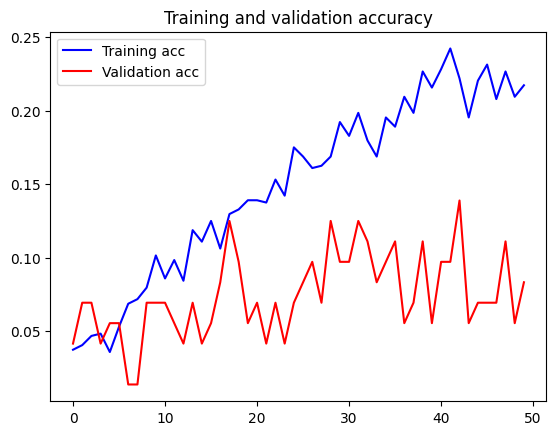

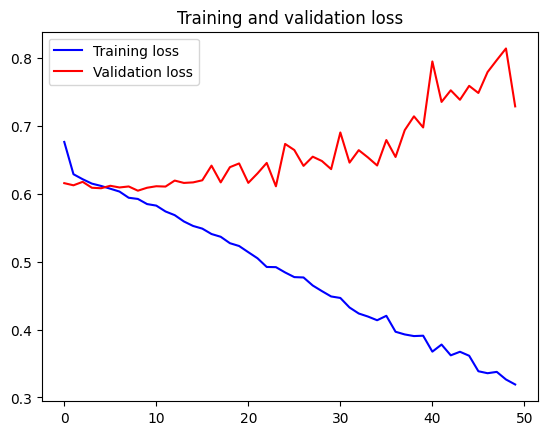

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.savefig('accuracy.png')

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.savefig('cross_entropy_loss.png')

The model successfully trained, and produced somewhat accurate results. However, it is not easy to visualize the success of the model, since binary cross-entropy accuracy is “all or nothing” - even if the model successfully predicts 11 weaknesses, but misclassifies 1, the accuracy for that particular object would have a score of 0.

Additionally, it’s plain to see that the CNN is overfitting. Considering how misleading accuracy is as a metric, loss is the best way to visualize how “on-point” the weakness predictions are, and the loss of the validation dataset only increases once the number of epochs reaches 3.

18/18 [==============================] - 1s 29ms/step
Enemy index:		 559
Predicted weaknesses:	 [1 0 0 0 0 1 0 1 0 1 0 0]
Actual weaknesses:	 [0 0 0 0 1 0 1 1 0 1 0 1]


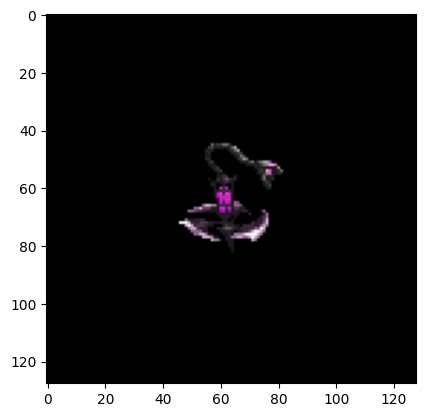

In [21]:
import random

index = random.randint(0,len(x_train))
prediction = model.predict(x_train[:index])
prediction[prediction > 0.5] = 1
prediction[prediction < 0.5] = 0
print('Enemy index:\t\t',index)
print("Predicted weaknesses:\t", prediction[0].astype(int))
plt.imshow(x_train[index])
print("Actual weaknesses:\t", y_train[index])

In an attempt to reduce the amount of overfitting, I decided to generalize the images using PCA. By splitting the image into 3 channels - R G B, I can obtain three instances of 128x128 image datasets (size of dataset being 712). Applying PCA to each of the three datasets with the number of primary components being 200, we can have an explained variance of 92% while reducing the number of dimensions by 98.77%. Given the primary components, we can then reconstruct the image (albeit, not a perfect reconstruction, but more than enough to tell what enemy it is). So for purposes related to prediction, the 200x3 tuples represent our 128x128x3 tuples with 92% confidence.

In [2]:
from sklearn.decomposition import PCA

X, Y = arrange_data(df)

X_r = X[:,:,:,0]
X_g = X[:,:,:,1]
X_b = X[:,:,:,2]


print(X_r.shape)
nsamples, nx, ny = X_r.shape

X_r = X_r.reshape(nsamples, nx*ny)

X_g = X_g.reshape(nsamples, nx*ny)

X_b = X_b.reshape(nsamples, nx*ny)

print(X_r.shape)

Shape of images: (712, 128, 128, 3)
Shape of labels: (712, 12)
(712, 128, 128)
(712, 16384)


In [7]:
component_number = 200

pca_r = PCA(n_components=component_number)
pca_r.fit(X_r)
pca_g = PCA(n_components=component_number)
pca_g.fit(X_g)
pca_b = PCA(n_components=component_number)
pca_b.fit(X_b)

tpca_r = pca_r.transform(X_r)
tpca_b = pca_b.transform(X_b)
tpca_g = pca_g.transform(X_g)

print(tpca_r.shape)

In [8]:
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

Blue Channel : 0.922918097639922
Green Channel: 0.9227585004409775
Red Channel  : 0.9205279540037736


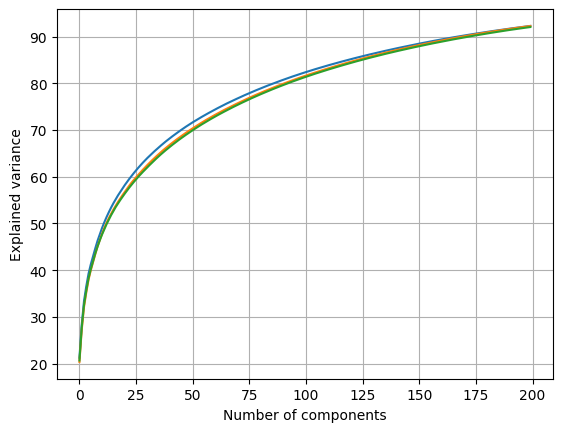

In [9]:
plt.grid()
plt.plot(np.cumsum(pca_b.explained_variance_ratio_ * 100))
plt.plot(np.cumsum(pca_g.explained_variance_ratio_ * 100))
plt.plot(np.cumsum(pca_r.explained_variance_ratio_ * 100))

plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')

In [10]:
r_arr = pca_r.inverse_transform(tpca_r)
b_arr = pca_b.inverse_transform(tpca_b)
g_arr = pca_g.inverse_transform(tpca_g)
print(r_arr.shape)

r_arr = r_arr.reshape(712, 128, 128,1)
b_arr = b_arr.reshape(712, 128, 128,1)
g_arr = g_arr.reshape(712, 128, 128,1)

print(r_arr.shape)

(712, 16384)
(712, 128, 128, 1)


In [11]:
tpca_r.shape

(712, 200)

In [12]:
compressed_image_merge = np.zeros(shape=(712,200,3))

compressed_image_merge[:,:,0] = tpca_r
compressed_image_merge[:,:,1] = tpca_g
compressed_image_merge[:,:,2] = tpca_b

compressed_image_merge.shape

(712, 200, 3)

In [13]:
def uncompress_image(compressed_instance):
    r_arr = pca_r.inverse_transform(compressed_instance[:,0])
    g_arr = pca_g.inverse_transform(compressed_instance[:,1])
    b_arr = pca_b.inverse_transform(compressed_instance[:,2])

    r_arr = r_arr.reshape(128, 128, 1)
    g_arr = g_arr.reshape(128, 128, 1)
    b_arr = b_arr.reshape(128, 128, 1)

    return cv2.merge([r_arr,g_arr,b_arr])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original image')

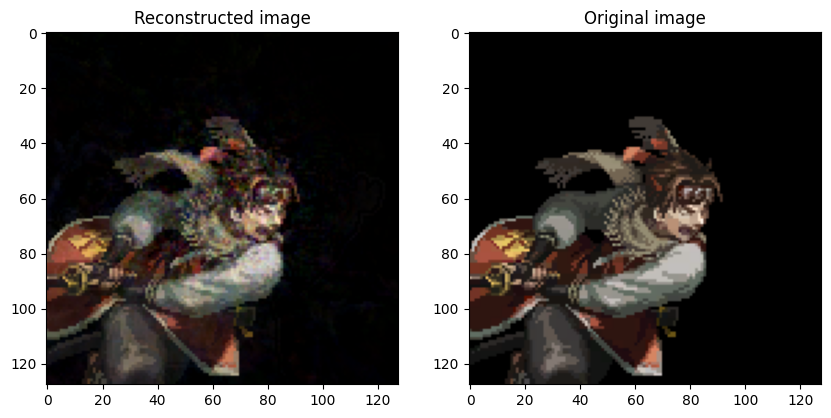

In [14]:
index = random.randint(0,len(X))

index = 0
fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(uncompress_image(compressed_instance=compressed_image_merge[index]))
plt.title('Reconstructed image')

fig.add_subplot(1, 2, 2)
plt.imshow(X[index])
plt.title('Original image')

As seen, it's possible to reduce images from 128x128x3 down to 200x3, AND for the images to be retrieved while maintaining 92% of the data.

I will use this process to create another nueral network (this time not CNN) with 200x3 input parameters.

I then constructed a simple neural network with 5 dense layers of decreasing number of nodes with an input shape of 200x3, and ran the model. The learning curve was extremely similar to the CNN, but the loss and accuracy were much more predictable over epochs, and it ran significantly faster (though, it also overfit much faster).

I know that oversized neural networks are extremely prone to overfitting, so I’ve elected to make a much smaller neural network: A flatten layer (200x3 -> 600), a dense layer (600->64), and an output layer (64->12). The model successfully trained, and generalizes much better over the previous rendition.


In [15]:
from sklearn.model_selection import train_test_split


X = compressed_image_merge
Y = Y # unchanged
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [16]:
X.shape

(712, 200, 3)

In [50]:
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, InputLayer

model = Sequential()
model.add(InputLayer(input_shape=(200,3)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='sigmoid'))

model.build(input_shape=(200,3))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 600)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               76928     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 12)                780       
                                                                 
Total params: 85,964
Trainable params: 85,964
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

BS = len(x_train)
EPOCHS = 50

history = model.fit(x=x_train,y=y_train,batch_size=BS,epochs=EPOCHS,validation_data=(x_test,y_test),steps_per_epoch=len(x_train)// BS)
model.save('model_dml_pca.h5')

Epoch 1/50
1/1 [==============================] - 0s 427ms/step - loss: 0.7509 - accuracy: 0.0422 - val_loss: 0.7208 - val_accuracy: 0.0699
Epoch 2/50
1/1 [==============================] - 0s 63ms/step - loss: 0.7055 - accuracy: 0.0422 - val_loss: 0.6945 - val_accuracy: 0.0629
Epoch 3/50
1/1 [==============================] - 0s 38ms/step - loss: 0.6677 - accuracy: 0.0510 - val_loss: 0.6735 - val_accuracy: 0.0629
Epoch 4/50
1/1 [==============================] - 0s 37ms/step - loss: 0.6366 - accuracy: 0.0650 - val_loss: 0.6568 - val_accuracy: 0.0490
Epoch 5/50
1/1 [==============================] - 0s 39ms/step - loss: 0.6107 - accuracy: 0.0738 - val_loss: 0.6434 - val_accuracy: 0.0490
Epoch 6/50
1/1 [==============================] - 0s 35ms/step - loss: 0.5889 - accuracy: 0.0826 - val_loss: 0.6328 - val_accuracy: 0.0490
Epoch 7/50
1/1 [==============================] - 0s 43ms/step - loss: 0.5698 - accuracy: 0.0931 - val_loss: 0.6242 - val_accuracy: 0.0420
Epoch 8/50
1/1 [==========

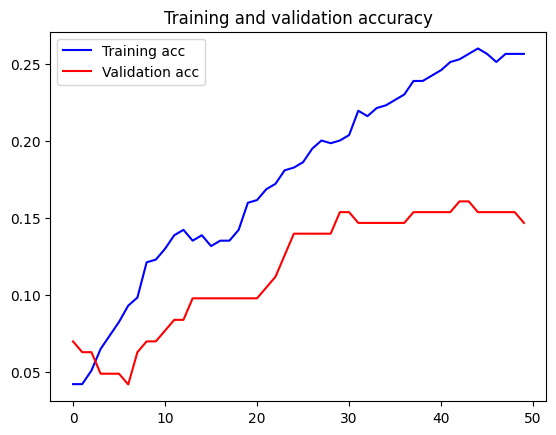

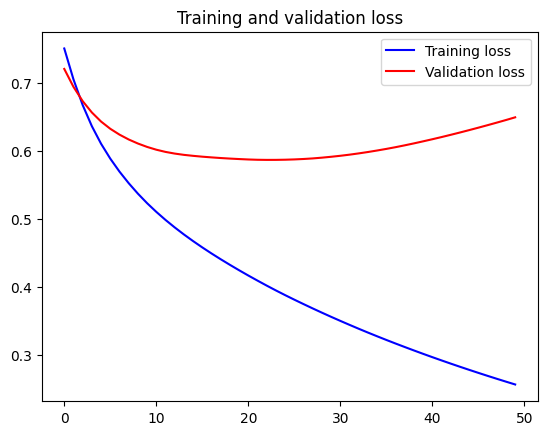

<Figure size 640x480 with 0 Axes>

In [52]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.savefig('accuracy.png')

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.savefig('cross_entropy_loss.png')

While the accuracy seems to have gone down past 20 epochs, the model actually hasn’t been getting worse, as seen in the validation loss. However, the validation loss certainly isn’t impressive either; guessing (50% confidence in all 12 weakness labels) has a loss of 0.7, which the model is barely better than! With that said, the accuracy is significantly better than guessing (0.5^12 = 0.00024), which means: When the neural network predicts incorrectly, it is incorrect by a significant margin (if true label = 1, predicted value = 0.1, for example), and if the neural network predicts correctly, it’s not correct by a significant margin (if true label = 1, predicted value = 0.6, for example).
	
To better visualize (and avoid overfitting) I instead created a CNN with only 1 weakness label instead of 12.


In [76]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('dataset.csv')


df_postive = df[df['Light'] == 1]

df_negative = df[df['Light'] == 0].sample(n=len(df_postive))

df = pd.concat([df_postive, df_negative], axis=0)

train, test = train_test_split(df, test_size=0.1)

x_train, y_train = arrange_data(dfin = train)

x_test, y_test = arrange_data(dfin = test)

y_train = np.array(y_train[:,4]).astype(float)

y_test = np.array(y_test[:,4]).astype(float)

Shape of images: (383, 128, 128, 3)
Shape of labels: (383, 12)
Shape of images: (43, 128, 128, 3)
Shape of labels: (43, 12)


In [81]:
from keras.applications import VGG16
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# freeze up to last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False


model = models.Sequential()

model.add(vgg_conv)

num_classes = 1

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='sigmoid'))

model.summary()
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss = 'binary_crossentropy', metrics=['accuracy'])

EPOCHS=50
BS = 64

# data augmentation to reduce overfit
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,horizontal_flip=True, fill_mode="nearest")

history = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS), validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS, epochs=EPOCHS)

model.save('Model_4d.h5')

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_23 (Flatten)        (None, 8192)              0         
                                                                 
 dense_55 (Dense)            (None, 1024)              8389632   
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_56 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 23,105,345
Trainable params: 15,470,081
Non-trainable params: 7,635,264
_________________________________________________________________
Epoch 1/50


c:\Users\Alex Dai\Documents\CMSC422\final_proj\direct_ml_env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\Alex Dai\AppData\Local\Temp\ipykernel_18336\3457047013.py:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS), validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS, epochs=EPOCHS)


5/5 [==============================] - 2s 152ms/step - loss: 1.0623 - accuracy: 0.4859 - val_loss: 0.6873 - val_accuracy: 0.5581
Epoch 2/50
5/5 [==============================] - 1s 123ms/step - loss: 0.7271 - accuracy: 0.4953 - val_loss: 0.7494 - val_accuracy: 0.4419
Epoch 3/50
5/5 [==============================] - 1s 124ms/step - loss: 0.7236 - accuracy: 0.5172 - val_loss: 0.6921 - val_accuracy: 0.4884
Epoch 4/50
5/5 [==============================] - 1s 128ms/step - loss: 0.7156 - accuracy: 0.5125 - val_loss: 0.7152 - val_accuracy: 0.4651
Epoch 5/50
5/5 [==============================] - 1s 136ms/step - loss: 0.6859 - accuracy: 0.5643 - val_loss: 0.6876 - val_accuracy: 0.5581
Epoch 6/50
5/5 [==============================] - 1s 141ms/step - loss: 0.6900 - accuracy: 0.5768 - val_loss: 0.6896 - val_accuracy: 0.5814
Epoch 7/50
5/5 [==============================] - 1s 122ms/step - loss: 0.6980 - accuracy: 0.5611 - val_loss: 0.6795 - val_accuracy: 0.5581
Epoch 8/50
5/5 [===============

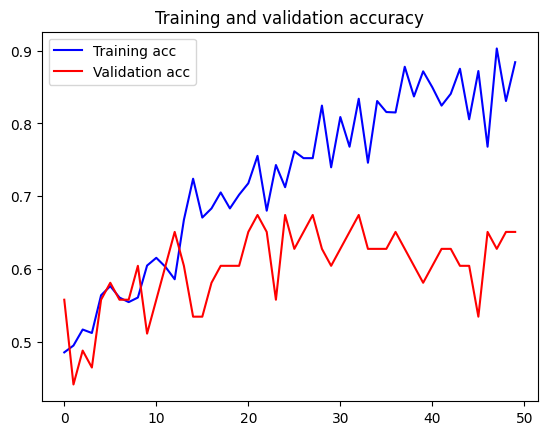

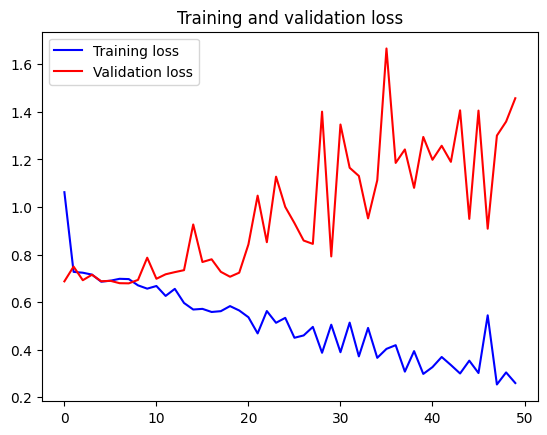

<Figure size 640x480 with 0 Axes>

In [82]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.savefig('accuracy.png')

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.savefig('cross_entropy_loss.png')

1
1/1 [==============================] - 0s 119ms/step
[[0.9296197]]


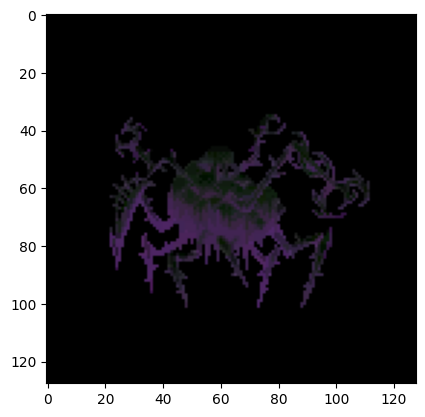

In [76]:
index = random.randint(0,len(x_train))

plt.imshow(x_train[index])
print(y_train[index])
print(model.predict(np.array([x_train[index],])))

This is a result of an unadulterated VGG16 model trained on 128x128x3 input dimensions, much like our original CNN model. With only 1 input label, we can see that the accuracy is very high (around 85%, but quite unstable), but the loss is uncharacteristically high (a 50% confidence is a loss of 0.7 using binary cross entropy, this has a loss of 0.9!).

Doing some research, I’ve stumbled across this post, explaining the issue. 
https://stats.stackexchange.com/questions/258166/good-accuracy-despite-high-loss-value


The reason the loss explodes, while the accuracy consistently increases is because: there are certain outliers that ‘blow up’ the loss function. Intuitively, I know Octopath Traveler has an even weakness spread of 20% - that is, 20% of enemies are weak to swords, 20% are weak to spears, etc etc. To enforce this constraint, the developers more or less “sprinkle” in weaknesses to enemies where the weaknesses don’t belong. These outliers are completely unpredictable, and can throw the loss metric out of the window for single-weakness predictions. The reason this doesn’t apply to full-set weakness predictions is because there are a couple of ‘unpredictable weaknesses’ at most per enemy (speaking from experience from playing the game) and so the loss doesn’t blow up because it’s constrained on average. However, with single weakness calculations, loss does break due to exceptions, and this consequence is only possible because there are, in fact, unpredictable exceptions in enemy design. Due to this, an appropriate loss metric might be mean root error.

Tangent aside; With that, we can numerically conclude that there are design anomalies in Octopath Traveler. To further enforce this fact, I will run the same code with the input variables using PCA (2 dense layers, 200x3 -> flatten -> 64 -> 12)


Below is the NN performed on the PCA reduction

In [83]:
from sklearn.model_selection import train_test_split


X = compressed_image_merge
Y_light = Y[:,4]
x_train, x_test, y_train, y_test = train_test_split(X, Y_light, test_size=0.2)

from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, InputLayer

model = Sequential()
model.add(InputLayer(input_shape=(200,3)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(200,3))

print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

BS = len(x_train)
EPOCHS = 50

history = model.fit(x=x_train,y=y_train,batch_size=BS,epochs=EPOCHS,validation_data=(x_test,y_test),steps_per_epoch=len(x_train)// BS)
model.save('model_dml_pca.h5')

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 600)               0         
                                                                 
 dense_57 (Dense)            (None, 64)                38464     
                                                                 
 dense_58 (Dense)            (None, 1)                 65        
                                                                 
Total params: 38,529
Trainable params: 38,529
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
1/1 [==============================] - 0s 389ms/step - loss: 0.7145 - accuracy: 0.6257 - val_loss: 0.6282 - val_accuracy: 0.6364
Epoch 2/50
1/1 [==============================] - 0s 45ms/step - loss: 0.6457 - accuracy: 0.6678 - val_loss: 0.6150 - val_accuracy: 0.6573
Epoch 3/50
1/1 [=============

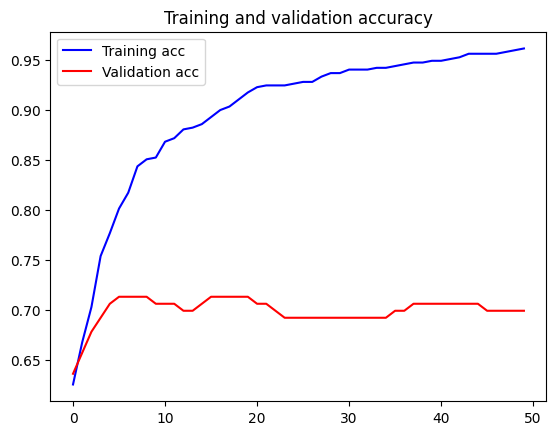

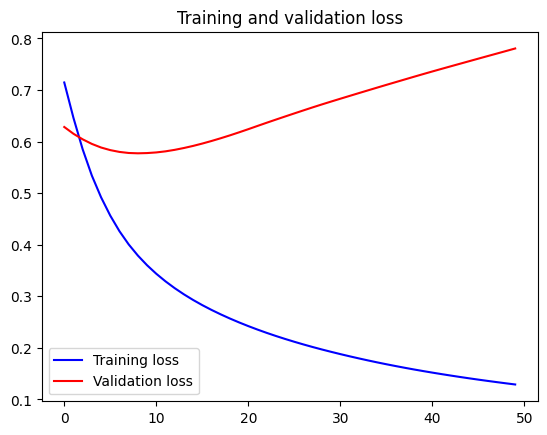

<Figure size 640x480 with 0 Axes>

In [84]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.savefig('accuracy.png')

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


plt.savefig('cross_entropy_loss.png')

With this, we can conclude that the ‘light’ weakness is only reliably predictable around 70% of the time! I could perform the same analysis on all other 12 weaknesses, but that would be redundant.


# Conclusion
### Is the problem realizable?
	Despite a low sample size, it is possible to train a neural network to predict weakness labels given an enemy sprite. A neural network that trains for all 12 labels is effective, but it is difficult to visualize its overall efficacy, and it’s prone to overfitting. We can, however, choose to create 12 neural networks to train for each weakness individually, which leads to a simpler result and room for analysis.
### How effective is dimensionality reduction with PCA?
	Performing dimensionality reduction is extremely effective for generating a consistent training curve, which can help visualize accuracy and loss change over epochs. Additionally, it can reduce the time for training by a magnitude of 100, depending on the size of your reduced neural network.
### How complex of a neural network do we need?
	For purposes of classification, excessive and complex layers can be strictly detrimental for both accuracy and loss. To be completely honest, I genuinely think VGG16 might be too complex of a CNN, which led to quick overfitting.
	This may be due to the low sample size, however, and with excessive amounts of images it may be beneficial for a complex neural network.
